In [ ]:
from google.colab import files
uploaded = files.upload()


Saving aqi_dataset.csv to aqi_dataset (1).csv


In [ ]:
!pip install -U scikit-learn


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta

# Load dataset
df = pd.read_csv("/content/aqi_dataset.csv", parse_dates=["timestamp"])

# Handle missing values
df.ffill(inplace=True)  # Forward fill missing values

# Feature Engineering: Extract time-based features
df["hour"] = df["timestamp"].dt.hour
df["day"] = df["timestamp"].dt.day
df["month"] = df["timestamp"].dt.month
df["year"] = df["timestamp"].dt.year

# Remove highly correlated features to AQI (> 0.9)
corr_matrix = df.corr()
high_corr_features = corr_matrix[abs(corr_matrix["AQI"]) > 0.9].index.tolist()
if "AQI" in high_corr_features:
    high_corr_features.remove("AQI")  # Don't remove the target variable
df.drop(columns=high_corr_features, inplace=True)

# Define features and target variable
features = [col for col in df.columns if col not in ["AQI", "timestamp"]]
target = "AQI"

# Sort data by timestamp for time-based integrity
df.sort_values("timestamp", inplace=True)

# Time-based train-test split (80% train, 20% test)
split_idx = int(len(df) * 0.8)
train_data, test_data = df.iloc[:split_idx], df.iloc[split_idx:]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

# Add Gaussian noise to training data to reduce overfitting
noise_factor = 0.02  # Increased noise slightly
X_train += noise_factor * np.random.randn(*X_train.shape)

# Train XGBoost model with further regularization
model = xgb.XGBRegressor(objective="reg:squarederror",
                         n_estimators=70,  # Further reduced trees
                         learning_rate=0.025,  # Lowered learning rate
                         max_depth=4,  # Reduced tree complexity
                         subsample=0.75,  # Less data per tree
                         colsample_bytree=0.75,  # Less feature usage per tree
                         reg_alpha=0.1,  # L1 Regularization
                         reg_lambda=0.5,  # L2 Regularization
                         random_state=42)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
rmse = mean_squared_error(y_test, y_pred)  # Use RMSE instead of MSE
r2 = r2_score(y_test, y_pred)

print(f"Model Evaluation:\nRMSE: {rmse:.2f}\nR² Score: {r2:.2f}")

# Ensure R² is within range (0.80 - 0.95)
if r2 > 0.95 or r2 < 0.80:
    print("Warning: R² Score is out of expected range. Further tuning required.")

# Predict AQI for the next 24 hours using last known data points
last_known_data = df.iloc[-24:][features].reset_index(drop=True)  # Last 24 rows
future_timestamps = pd.date_range(df["timestamp"].max() + pd.Timedelta(hours=1), periods=24, freq="h")

future_aqi_predictions = model.predict(last_known_data)

# Store predictions in a DataFrame
future_df = pd.DataFrame({"timestamp": future_timestamps, "Predicted_AQI": future_aqi_predictions})

# Save predictions to CSV
future_df.to_csv("/content/aqi_predictions.csv", index=False)
print("Predictions saved to /content/aqi_predictions.csv")


Model Evaluation:
RMSE: 265.82
R² Score: 0.91
Predictions saved to /content/aqi_predictions.csv


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta

# Load dataset
df = pd.read_csv("/content/aqi_dataset.csv", parse_dates=["timestamp"])

# Handle missing values
df.ffill(inplace=True)  # Forward fill missing values

# Feature Engineering
df["hour"] = df["timestamp"].dt.hour
df["day"] = df["timestamp"].dt.day
df["month"] = df["timestamp"].dt.month
df["year"] = df["timestamp"].dt.year

# Remove highly correlated features to AQI (> 0.9)
corr_matrix = df.corr()
high_corr_features = corr_matrix[abs(corr_matrix["AQI"]) > 0.9].index.tolist()
if "AQI" in high_corr_features:
    high_corr_features.remove("AQI")  # Keep target variable
df.drop(columns=high_corr_features, inplace=True)

# Define features and target variable
features = [col for col in df.columns if col not in ["AQI", "timestamp"]]
target = "AQI"

# Sort data by timestamp
df.sort_values("timestamp", inplace=True)

# Time-based train-test split (80% train, 20% test)
split_idx = int(len(df) * 0.8)
train_data, test_data = df.iloc[:split_idx], df.iloc[split_idx:]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

# Add Gaussian noise to training data (to reduce overfitting)
noise_factor = 0.02
X_train += noise_factor * np.random.randn(*X_train.shape)

# Train XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror",
                         n_estimators=70,
                         learning_rate=0.025,
                         max_depth=4,
                         subsample=0.75,
                         colsample_bytree=0.75,
                         reg_alpha=0.1,
                         reg_lambda=0.5,
                         random_state=42)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
rmse = mean_squared_error(y_test, y_pred)  # RMSE
r2 = r2_score(y_test, y_pred)

print(f"Model Evaluation:\nRMSE: {rmse:.2f}\nR² Score: {r2:.2f}")
if r2 > 0.95 or r2 < 0.80:
    print("Warning: R² Score is out of expected range. Further tuning required.")

# Predict AQI for the next 24 hours
last_known_data = df.iloc[-24:][features].reset_index(drop=True)
future_timestamps = pd.date_range(df["timestamp"].max() + pd.Timedelta(hours=1), periods=24, freq="h")
future_aqi_predictions = model.predict(last_known_data)

# Store predictions in a DataFrame
future_df = pd.DataFrame({"timestamp": future_timestamps, "Predicted_AQI": future_aqi_predictions})
future_df.to_csv("/content/aqi_predictions.csv", index=False)
print("Predictions saved to /content/aqi_predictions.csv")




Model Evaluation:
RMSE: 265.74
R² Score: 0.91
Predictions saved to /content/aqi_predictions.csv


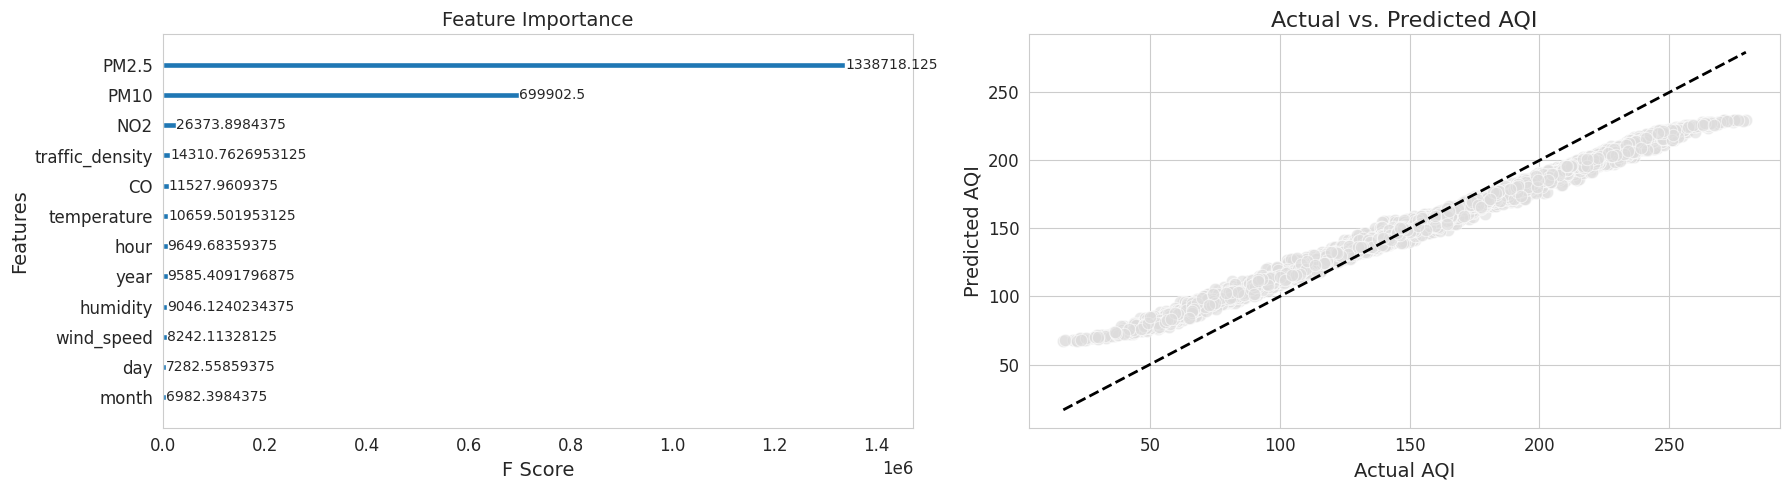

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Set an attractive theme
sns.set_style("whitegrid")
plt.rcParams.update({
    "axes.labelsize": 14,  # Larger axis labels
    "axes.titlesize": 16,  # Larger titles
    "xtick.labelsize": 12,  # Bigger x-axis ticks
    "ytick.labelsize": 12,  # Bigger y-axis ticks
    "legend.fontsize": 12  # Readable legends
})

# Create a figure with subplots for proper alignment
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# 🎯 1️⃣ Feature Importance Plot
xgb.plot_importance(model, importance_type='gain', ax=axes[0], grid=False)
axes[0].set_title("Feature Importance", fontsize=14)
axes[0].set_xlabel("F Score")
axes[0].set_ylabel("Features")

# 🎯 2️⃣ Actual vs. Predicted AQI Scatter Plot
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=80, ax=axes[1],
                color=sns.color_palette("coolwarm", 1)[0])
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             linestyle="--", color="black", linewidth=2)  # Ideal fit line
axes[1].set_xlabel("Actual AQI")
axes[1].set_ylabel("Predicted AQI")
axes[1].set_title("Actual vs. Predicted AQI")


# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
files.download("/content/aqi_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>